In [1]:
%pylab inline
import numpy as np
from handy import quantile
from astropy.io import fits
import h5py
from mimo_01 import ln_LH
from dynesty import NestedSampler
import sys
import multiprocessing
from scipy import stats

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# load isochrone model

In [2]:
IMF_form = 'Salpeter'
model_path = 'isochrone_model/iso_model_s.h5'
model_path = '../a_catalog/MF_2022/iso_model/iso_model.h5'
parafit = ln_LH.MiMO(model_path)

# Input the fitting data

In [3]:
with h5py.File('fitting_data/NGC_2682.h5', 'r') as fp:
    cl = fp['cl'][...]

    fs_mag = fp['fs_mag'][...]
    fs_color = fp['fs_color'][...]
    fs_mag_err = fp['fs_mag_err'][...]
    fs_color_err = fp['fs_color_err'][...]


mag = cl['correct_phot_g_mean_mag']
color = cl['bp_rp']

m_err = cl['phot_g_mean_mag_error']
c_err = (cl['phot_bp_mean_mag_error']**2 + cl['phot_rp_mean_mag_error']**2 + 0.01**2)**0.5

obs_pts = ln_LH.gener_obs_P(mag, color, m_err, c_err)

FS = ln_LH.Fs_prob(color, mag, fs_color, fs_mag, fs_color_err, fs_mag_err, smooth=True, c_smooth=1)
fs_prob = FS.fs_prob

# Setup the prior and posterior

In [4]:
mod_param_lim = dict(
    lgt_range=('u', 6.2, 10.15),
    # feh_range=('n', feh_min, feh_max, feh_avg, feh_err),
    feh_range=('u', -2.1, 0.45),
    dm_range=('u', 5, 15),
    av_range=('u', 0, 3),
    mf_range=('u', -5, 2),
    fb_range=('u',0, 1),
    #     gq_range=('u',-5, 5),
    f_fs_range=('u', 0, 1)
)

def prior_transform(u):
    from scipy import stats

    res = np.empty_like(u)
    for i, name in enumerate(mod_param_lim):
        lim = mod_param_lim[name]
        if lim[0] == 'u':
            a, b = lim[1], lim[2]
            res[i] = a + (b - a) * u[i]
        elif lim[0] == 'n':
            a, b, m, s = lim[1], lim[2], lim[3], lim[4]
            a, b = (a - m) / s, (b - m) / s
            res[i] = stats.truncnorm.ppf(u[i], a, b, loc=m, scale=s)
    return res

bound = 'multi'
nlive = 1000
ndim = 7
niter = 5000000
dlogz = 0.1

def lnprob(args):
    lgt_, feh_, dm_, Av_, mf_alpha_, f_b_,f_fs_ = args
    IMF_args_ = [mf_alpha_]
    return parafit.cl_p(obs_pts, lgt_, feh_, dm_, Av_, IMF_form, IMF_args_, f_b_, 0.0, fs_prob=fs_prob, f_fs=f_fs_)

# Run nested sampling

In [5]:


sampler = NestedSampler(lnprob, prior_transform, ndim, bound=bound, sample='rwalk',
                        nlive=nlive)
sampler.run_nested(dlogz=dlogz, maxiter=niter, print_progress=False)


# Parameter estimation

In [12]:
feh_min = -2.1
feh_max = 0.45

wgt = np.exp(sampler.results.logwt - max(sampler.results.logwt))
res_std = np.array([quantile(sampler.results.samples.T[i], weights=wgt, nsig=[0, -1, 1, -2, 2]) for i in range(ndim)])


lgt_f, feh_f, dm_f, Av_f,mf_f,fb_f, fs_f = res_std[:,0]




# Membership probability

In [13]:
_oc_best_fit = parafit.cl_p(obs_pts, lgt_f, feh_f, dm_f, Av_f, 
                       IMF_form, [mf_f], fb_f, 0.0, fs_prob=fs_prob, f_fs=fs_f,cal_single=True)
p_member = _oc_best_fit.p_member

# Download the bestfit isochrone and plot

In [20]:
from parsec_query import ParsecQuery
cmd = ParsecQuery(version='cmd_3.4')
photsys_file_g_edr3 = 'tab_mag_odfnew/tab_mag_gaiaEDR3.dat'

iso_f = cmd.query_isochrones(lgt=lgt_f, MeH=feh_f,
                           extinction_av=Av_f,photsys_file=photsys_file_g_edr3)

# corner plots

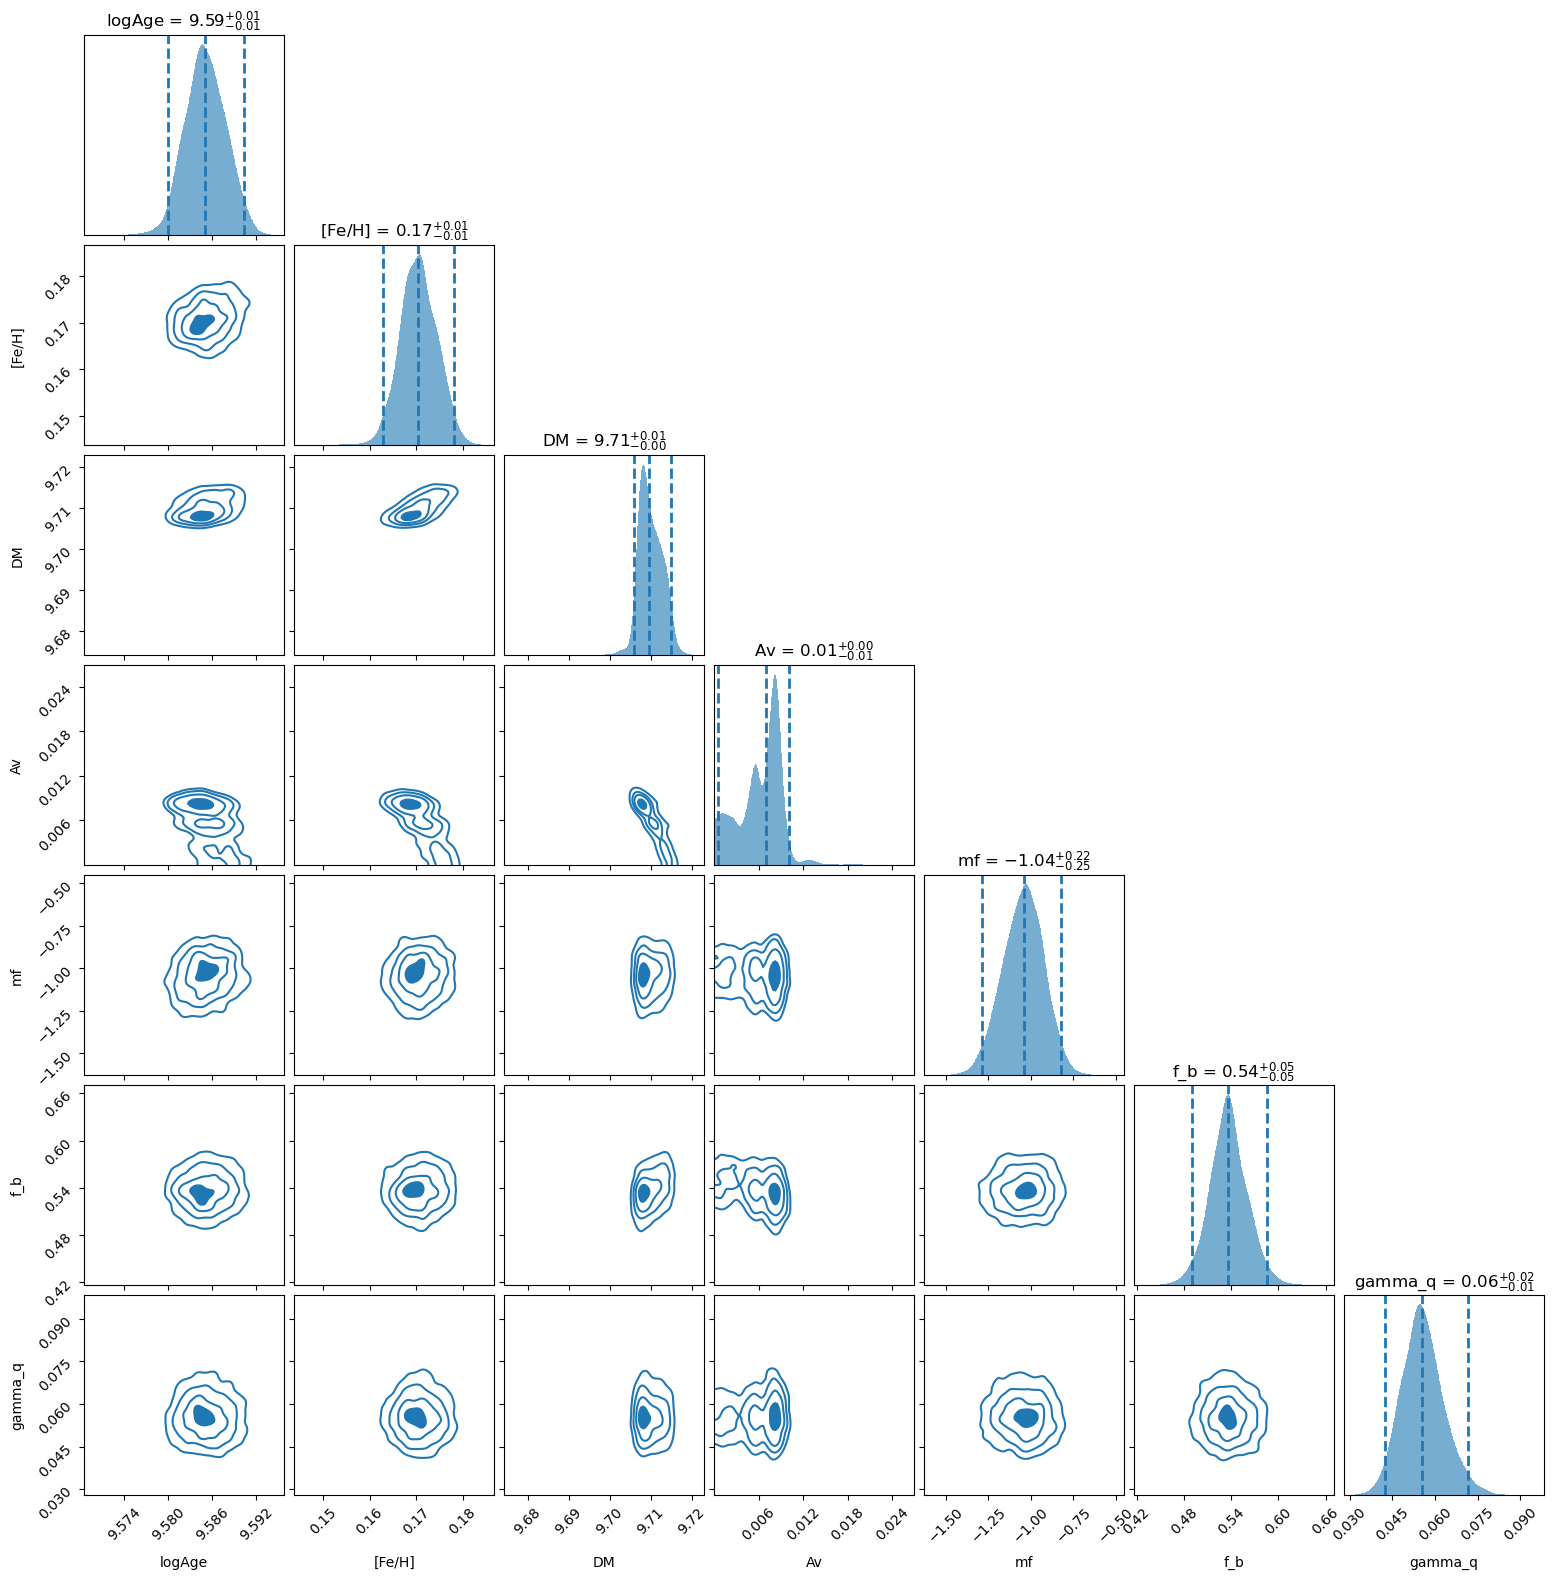

In [43]:
from dynesty import plotting as dyplot
from scipy.stats import norm
dyplot.cornerplot(sampler.results,
                  color='C0',
                  quantiles=[0.025,0.5,0.975],
                  labels=['logAge','[Fe/H]','DM','Av','mf','f_b','gamma_q','f_fs'],
                 show_titles=True);


# CMD results

Text(0, 0.5, 'G')

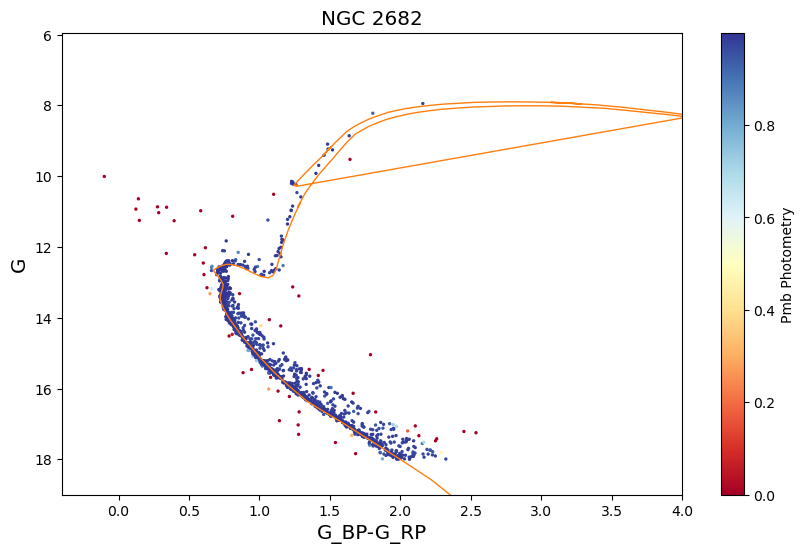

In [25]:
figure(figsize=(10,6))
title('NGC 2682',fontsize='x-large')
scatter(color,mag,s=2,c=p_member,cmap='RdYlBu')
colorbar(label='Pmb Photometry')
iso_f = iso_f[iso_f['label']<8]
plot(iso_f['G_BPmag']-iso_f['G_RPmag'],iso_f['Gmag']+dm_f,label='F',c='C1',lw=1)

ylim(19,min(mag)-2)
xlim(min(color)-0.3,4)

xlabel('G_BP-G_RP',fontsize='x-large')
ylabel('G',fontsize='x-large')